## Обучаем первую модель на MNIST

План на сегодня: пишем первый пайплайн для обучения

1. Пытаемся понять, какие компоненты нам нужны для обучения любой модели
2. Выясняем, что многое уже есть в Pytorch
3. Собираем наш первый скрипт для обучения на датасете MNIST

### 1. Разбираемся с данными

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

#### 1.1. Организуем доступ к данным с `torch.utils.data.Dataset`

Датасет в pytorch - это объект класса, в котором реализовано два обязательных метода: `__getitem__(self, index: int)` (получение одиночного примера по индексу) и `__len__(self)` (получение общего количества примеров). Этих методов достаточно, чтобы разбивать датасет на минибатчи  - это работу делает класс `torch.utils.DataLoader` с помощью различных семплеров, с ними мы понакомимся позже

In [1]:
import torch

torch.manual_seed(42)

In [2]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, n: int) -> None:
        super().__init__()
        self.data = torch.arange(n * 3).view((n, 3))
        self.labels = torch.randint(0, 5, size=(n,))

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.data[index], self.labels[index]

    def __len__(self) -> int:
        return len(self.data)


dataset = MyDataset(n=10)
print(dataset[0])
print(len(dataset))

(tensor([0, 1, 2]), tensor(2))
10


Итерируемся по датасету:

In [3]:
dataset = MyDataset(10)
for i in range(len(dataset)):
    print(dataset[i])

(tensor([0, 1, 2]), tensor(3))
(tensor([3, 4, 5]), tensor(4))
(tensor([6, 7, 8]), tensor(0))
(tensor([ 9, 10, 11]), tensor(4))
(tensor([12, 13, 14]), tensor(1))
(tensor([15, 16, 17]), tensor(2))
(tensor([18, 19, 20]), tensor(0))
(tensor([21, 22, 23]), tensor(0))
(tensor([24, 25, 26]), tensor(2))
(tensor([27, 28, 29]), tensor(1))


#### 1.2. Пакуем данные в батчи с `torch.utils.data.Dataloader`

У `torch.utils.data.Dataloader` много аргументов, на практике чаще всего используются
- `dataset` - объект, поддерживающий методы `__getitem__` и `__len__` (вопрос: можно ли передать список? словарь? множество?)
- `batch_size` - размер мини-батча
- `shuffle` - нужно ли перетасовать индексы перед нарезкой на минибатчи (это всегда стоит делать с обучающими данными, почему?)
- `num_workers` - количество процессов, которые будут загружать данные - иногда позволяет ускорить обучение (подумайте, в каком случае?)

In [4]:
from torch.utils.data import DataLoader

my_loader = DataLoader(
    dataset=dataset,
    batch_size=4,
    shuffle=True,
    # drop_last=
)

In [5]:
for i, batch in enumerate(my_loader):
    x, y = batch
    if i == 0:
        print(x)
        print(y)

tensor([[24, 25, 26],
        [ 6,  7,  8],
        [21, 22, 23],
        [15, 16, 17]])
tensor([2, 0, 0, 2])


#### 1.3. Посмотрим на MNIST

- какие атрибуты есть у объекта `torchvision.datasets.MNIST`?
- как выглядит одно наблюдение?

In [6]:
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    "data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),  # что это?
)
test_dataset = datasets.MNIST(
    "data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

In [7]:
isinstance(train_dataset, Dataset)

True

In [8]:
x, y = train_dataset[0]
print(x.shape)
print(y)

torch.Size([1, 28, 28])
5


**Задание 1 (1 балл)**. Используя `matplotlib`, выведите по одному примеру изображения для всех классов

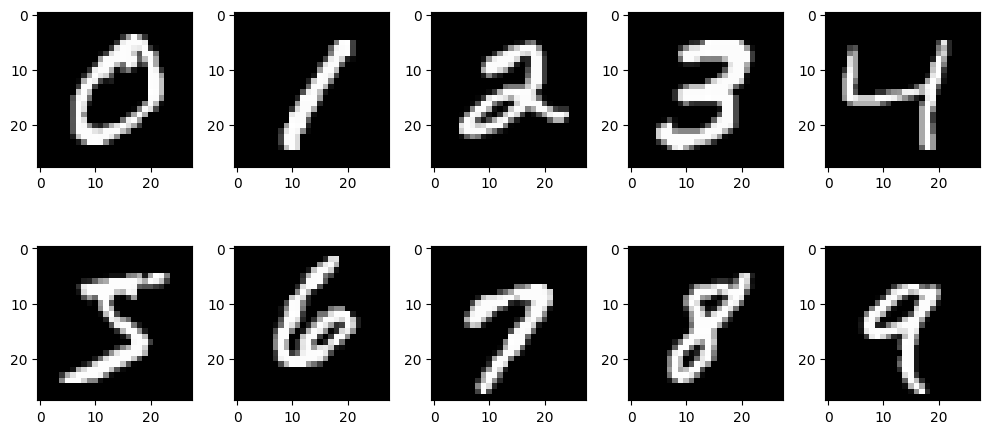

In [9]:
import matplotlib.pyplot as plt
images_per_class = [None] * 10

# Проходим по датасету и сохраняем по одному изображению для каждого класса
for img, label in train_dataset:
    if all(images_per_class):
        break
    if images_per_class[label] is None:
        images_per_class[label] = (img, label)
    # Если для всех классов нашли изображения, останавливаем цикл
    

# Визуализация изображений
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, (img, label) in enumerate(images_per_class):
    ax = axs[i // 5, i % 5]
    ax.imshow(img.squeeze(), cmap='gray')  

plt.tight_layout()
plt.show()
### ВАШ ХОД

Попробуем получить минибатч:

In [10]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Что возвращает `iter()`?

In [11]:
batch: tuple[torch.Tensor, torch.Tensor] = next(iter(train_loader))
x, y = batch
print(x.shape)
print(y.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


Со свёрточными сетями мы познакомимся позже, сейчас же мы будем экспериментировать с обычными полносвязными сетями, но для этого нам нужно будет преобразовать форму батча из `(batch_size, channels, width, height)` в `(batch_size, channels * width * height)`:

**Задание 2 (1 балл)**. Есть несколько способов изменить форму (shape) тензора. Приведите все знаковые вам способы привести батч с изображениями в форму `(batch_size, channels * width * height)`

In [12]:
batch_size, channels, width, height = x.shape
input_dim = channels * width * height
x_reshaped = x.reshape(batch_size, input_dim)
print(x_reshaped.shape)
x_reshaped = x.view(batch_size, input_dim)
print(x_reshaped.shape)
x_reshaped = x.flatten(start_dim=1)
print(x_reshaped.shape)
### ВАШ ХОД

torch.Size([4, 784])
torch.Size([4, 784])
torch.Size([4, 784])


Ура, с данными вроде разобрались! Теперь разберёмся с моделью

### 2. Реализуем модель с помощью `torch.nn.Module`

#### 2.1. Описываем параметры модели и прямой проход

Для простоты будем строить небольшую нейронку из двух полносвязных слоёв и `tanh` в качестве функции активации.

$\text{logits} = w_2^T(\tanh(w_1^T x + b_1)) + b_2$

Какие параметры должны быть в линейном слое?

In [13]:
hidden_dim = 128  # размерность скрытого слоя
n_classes = 10

# первый слой
w1 = torch.randn((input_dim, hidden_dim), requires_grad=True)
b1 = torch.randn(hidden_dim, requires_grad=True)

# второй слой
w2 = torch.randn((hidden_dim, n_classes), requires_grad=True)
b2 = torch.randn(n_classes, requires_grad=True)

h = x.flatten(1) @ w1 + b1
print(h.grad_fn)
print(h.shape)

# применяем нелинейность перед применением следующего слоя
h = h.tanh()

h = h @ w2 + b2
print(h.grad_fn)
print(h.shape)

torch.Size([4, 128])
torch.Size([4, 10])


In [14]:
h

tensor([[  6.0172,   7.4072, -20.6861,   8.9256,  -5.4395,  -6.3682,   0.0770,
           6.8565, -20.1673,  -9.1324],
        [ -8.9641, -15.7704, -12.9448,   2.2937, -24.6292, -14.9430,  -0.0394,
          -3.6719, -27.6249,  -9.3068],
        [ -4.3937,  -0.6097, -28.6687,   7.9132, -10.3090,  -3.1383, -18.3530,
           0.4476, -16.2507, -17.0004],
        [ -3.8893,   4.6379,  -6.8515,  10.1379,  -4.4632,   4.5285,  -7.7709,
          -2.0474, -12.9890,  -1.3313]], grad_fn=<AddBackward0>)

Из этих выходных данных нам хотелось бы получить вероятностное распределение над возможными классами, то есть нужно как-то нормализовать эти активации, для этого обычно используется функция `softmax`:

In [15]:
z = torch.randn(10)
torch.softmax(z, 0)
# zz = torch.exp(z) / torch.exp(z).sum()
# zz.sum()

tensor([0.0420, 0.2254, 0.0424, 0.1480, 0.1133, 0.0393, 0.0123, 0.0224, 0.2780,
        0.0768])

Применим к нашим данным:

In [16]:
h.softmax(dim=1)

tensor([[3.8971e-02, 1.5646e-01, 9.8543e-14, 7.1426e-01, 4.1224e-07, 1.6286e-07,
         1.0255e-04, 9.0202e-02, 1.6557e-13, 1.0264e-08],
        [1.1737e-05, 1.2991e-08, 2.1915e-07, 9.0944e-01, 1.8462e-12, 2.9712e-08,
         8.8208e-02, 2.3332e-03, 9.2312e-14, 8.3315e-06],
        [4.5170e-06, 1.9870e-04, 1.2952e-16, 9.9921e-01, 1.2186e-08, 1.5851e-05,
         3.9118e-12, 5.7198e-04, 3.2019e-11, 1.5130e-11],
        [8.0301e-07, 4.0556e-03, 4.1519e-08, 9.9229e-01, 4.5237e-07, 3.6351e-03,
         1.6557e-08, 5.0660e-06, 8.9696e-11, 1.0367e-05]],
       grad_fn=<SoftmaxBackward0>)

Обратите внимание: классы получились совсем не равновероятны, хотя мы ещё не учили модель. Подумайте, почему так произошло?
Подробнее это мы обсудим на следующей практике.

Параметры нашей модели находятся в глобальной области видимости. Решение - спрятать всё внутрь класса-наследника `torch.nn.Module`

#### 2.2. Реализуем двуслойный перцептрон как наследник `nn.Module`

**Задание 3 (1 балл)**. Прочитайте документацию к классам `torch.nn.Module` и `torch.nn.Parameter`. Почему при задании параметров модели не стоит их создавать просто как `torch.tensor(..., requires_grad=True)`?

In [17]:
Если мы будем использовать torch.tensor(..., requires_grad=True), то тензор не будет зарегистрирован как параметр, и оптимизаторы, такие как torch.optim, не смогут обновлять его значения во время обучения.

SyntaxError: invalid syntax (3437587949.py, line 1)

**Задание 4 (1 балл)**. Чтобы сделать наш модуль рабочим, нужно определить два метода: `__init__` и `forward`. Реализуйте метод `forward`, который возвращает логиты, т. е. выход последнего линейного слоя без применения функции активации `softmax`

In [18]:
class SimpleNet(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.b1 = torch.nn.Parameter(torch.randn(hidden_dim))

        self.w2 = torch.nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.b2 = torch.nn.Parameter(torch.randn(output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ВАШ ХОД
        x = torch.matmul(x, self.w1) + self.b1
        logits = torch.matmul(x, self.w2) + self.b2
        return logits

In [19]:
model = SimpleNet(input_dim, hidden_dim, n_classes)
model(x).shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (112x28 and 784x128)

Параметры модели:

In [ ]:
list(model.named_parameters())

Вручную обновлять значения многих параметров очень неудобно. К счастью, за нас это сделает оптимизатор

In [ ]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
print(optimizer)

#### 2.1. Считаем ошибку и градиенты на одном минибатче

In [ ]:
# получим предсказания и посчитаем ошибку
predictions = model.forward(x)
loss = torch.nn.functional.cross_entropy(predictions, y)
print(loss)
# рассчитаем градиенты и обновим параметры
loss.backward()
optimizer.step()

# не забудем почистить градиенты, мы не хотим их накапливать
optimizer.zero_grad()

**Задание 5 (1 балл)**: Посчитайте значение перекрёстной энтропии самостоятельно по формуле, сверьтесь с результатом выше

In [ ]:
# посчитайте ce_loss на основе значений переменных `predictions` и `y`
# ВАШ ХОД
ce_loss = ...
assert torch.allclose(ce_loss, loss), f"{ce_loss} != {loss}"

### 3. Обучение

#### 3.1. Шаг обучения: что мы делаем с каждым минибатчем данных

In [ ]:
def training_step(
    batch: tuple[torch.Tensor, torch.Tensor],
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
) -> tuple[torch.Tensor, torch.Tensor]:
    # прогоняем батч через модель
    x, y = batch
    predictions = model(x)
    # оцениваем значение ошибки
    loss = torch.nn.functional.cross_entropy(predictions, y)
    # обновляем параметры
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # возвращаем значение функции ошибки для логирования
    return loss, predictions

Для тестовых батчей нам не нужны градиенты, поэтому расчёты делаем внутри контекста `torch.no_grad`

In [ ]:
def test_step(
    batch: tuple[torch.Tensor, torch.Tensor], model: torch.nn.Module
) -> tuple[torch.Tensor, torch.Tensor]:
    x, y = batch
    with torch.no_grad():
        predictions = model(x)
        # оцениваем значение ошибки
        loss = torch.nn.functional.cross_entropy(predictions, y)
    return loss, predictions

#### 3.2. А теперь: что мы хотим делать в каждой эпохе?

**Задание 6 (2 балла)**: Напишите функцию для запуска одной эпохи (обучающей или тестовой), которая итерируется по минибатчам, обрабатывает их и в конце выводит среднюю ошибку и точность классификации. Запустите обучение на 10-15 эпох, добейтесь точности более 92% на тестовой выборке.

In [ ]:
def run_epoch(
    is_train: bool,
    dataloader: DataLoader,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
) -> None:
    # ВАШ ХОД
    
    for batch in dataloader:
        ...

    epoch_loss = ...
    accuracy = ...
    print(f"Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

Создадим модель, оптимизатор и загрузчики данных и запустим обучение:

In [ ]:
n_epochs = 15
for i in range(n_epochs):
    print(f"Epoch {i} train:")
    run_epoch(True, train_loader, model, optimizer)
    print(f"Epoch {i} test:")
    run_epoch(False, test_loader, model, optimizer)